In [2]:
import math
import os

import numpy as np
import pandas as pd
from IPython.display import display

from data import download, extract, get_repo_root, get_timestamps

In [3]:

url = "https://obj.umiacs.umd.edu/eventprediction/transactions.tgz"
data_dir = os.path.join(get_repo_root(), "data")
tarfile = download(url, data_dir)
extracted_files = extract(tarfile)
datafile = os.path.join(data_dir, extracted_files[0])
datafile_base, datafile_ext = os.path.splitext(datafile)
train_path = datafile_base + "_train" + datafile_ext
test_path = datafile_base + "_test" + datafile_ext
train_test_thres_year=2018
seq_len=10
consider_card = False

Checking c:\Users\monte\code\event_prediction\data\transactions.tgz to extract files...
Extracted files: ['card_transaction.v1.csv']


In [4]:
# file_path = './data/card_transaction.v1.csv'
# train_path = './data/card_transaction_train.csv'
# test_path = './data/card_transaction_test.csv'
# train_test_thres_year=2018
# seq_len=10
# consider_card = False

# Load and preprocess dataset

In [5]:
data = pd.read_csv(datafile)
data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [6]:
timestamps = get_timestamps(data[['Year', 'Month', 'Day', 'Time']])
timestamps.head()

0   2002-09-01 06:21:00
1   2002-09-01 06:42:00
2   2002-09-02 06:22:00
3   2002-09-02 17:45:00
4   2002-09-03 06:23:00
dtype: datetime64[ns]

In [7]:
# Add an hour column to our dataframe
data['Hour'] = timestamps.dt.hour
zero_time = pd.to_datetime(np.zeros(len(data)))
total_seconds = (timestamps - zero_time).dt.total_seconds().astype(int)
total_minutes = total_seconds//60
# Add a column for total minutes from timestamp=0 to our datafrae
data['total_minutes'] = total_minutes

In [14]:
# Sort the data in transaction order
sort_columns = ['User', 'Card', 'total_minutes'] if consider_card else ['User', 'total_minutes']
sorted_data = data.sort_values(by=sort_columns)
# if consider_card:
#     new_data = data.sort_values(by=sort_columns)
# else:
#     new_data = data.sort_values(by=sort_columns)

# Add a column numbering the transactions in order
sorted_data['rownumber'] = np.arange(len(sorted_data))
# Remove the dollar sign from the amount column and convert it to float
sorted_data['Amount'] = sorted_data['Amount'].apply(lambda x: x[1:]).astype(float)
# Note that amount values <= 1 are set to 1 before taking log
sorted_data['Amount'] = sorted_data['Amount'].apply(lambda amt: max(1, amt)).apply(math.log)

# Split train/test

In [18]:
print('Bin Percentage')
display(sorted_data['Year'].value_counts().sort_index()/len(sorted_data['Year']))
print('\nCumulative Percentage')
display(sorted_data['Year'].value_counts().sort_index().cumsum()/len(sorted_data['Year']))

Bin Percentage


1991    0.000065
1992    0.000211
1993    0.000344
1994    0.000587
1995    0.000858
1996    0.001228
1997    0.002040
1998    0.003213
1999    0.004849
2000    0.007288
2001    0.010579
2002    0.014382
2003    0.019125
2004    0.024480
2005    0.030617
2006    0.037266
2007    0.043650
2008    0.050169
2009    0.055580
2010    0.061149
2011    0.064401
2012    0.066053
2013    0.067697
2014    0.068575
2015    0.069766
2016    0.070075
2017    0.070667
2018    0.070596
2019    0.070691
2020    0.013798
Name: Year, dtype: float64


Cumulative Percentage


1991    0.000065
1992    0.000276
1993    0.000619
1994    0.001206
1995    0.002064
1996    0.003292
1997    0.005332
1998    0.008545
1999    0.013394
2000    0.020682
2001    0.031261
2002    0.045643
2003    0.064768
2004    0.089249
2005    0.119866
2006    0.157131
2007    0.200781
2008    0.250950
2009    0.306530
2010    0.367679
2011    0.432080
2012    0.498134
2013    0.565830
2014    0.634406
2015    0.704172
2016    0.774247
2017    0.844915
2018    0.915510
2019    0.986202
2020    1.000000
Name: Year, dtype: float64

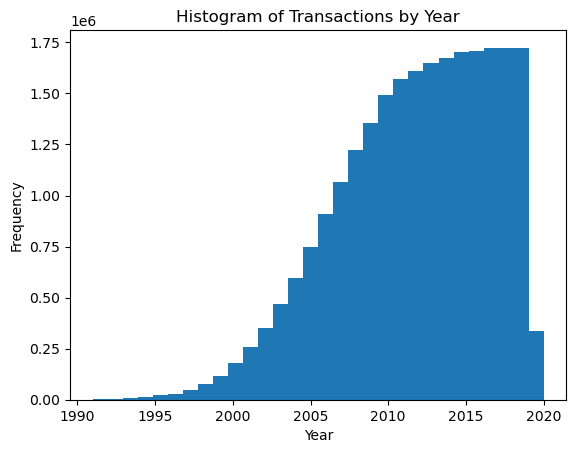

In [24]:
import matplotlib.pyplot as plt

plt.hist(sorted_data['Year'], bins=len(sorted_data['Year'].unique()))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Transactions by Year')
plt.show()


In [82]:
train_data = sorted_data.loc[sorted_data['Year'] < train_test_thres_year]
basic_test_data = sorted_data.loc[sorted_data['Year'] >= train_test_thres_year]

In [83]:
train_user = set(train_data['User'].unique())
test_user = set(basic_test_data['User'].unique())
train_test_user = train_user.intersection(test_user)
test_only_user = test_user.difference(train_user)

In [84]:
groupby_columns = ['User', 'Card'] if consider_card else ['User']

In [91]:
def get_index(x, seq_len):
    return x.index[-(seq_len-1):]

In [86]:
test_extra_index = train_data.loc[train_data['User'].isin(train_test_user)].groupby(groupby_columns).apply(get_index, seq_len)
test_extra_index = test_extra_index.explode()

In [88]:
test_data = pd.concat([sorted_data.loc[test_extra_index], basic_test_data])

In [90]:
test_data.sort_values(by=sort_columns, inplace=True)

In [174]:
print(train_data.duplicated().any(), test_data.duplicated().any())

False False False


In [184]:
print(f'Train size: {train_data.shape}, test size: {test_data.shape}')

Train size: (13798849, 17), val size: (1685991, 17), test size: (8929150, 17)


# Generate Static Fields

For payment data (IBM synthetic):

•	Average dollar amount of the user

•	standard deviation dollar amount of the user

•	Most frequent MCC

•	Most frequent Use Chip

In [92]:
def get_top_item(x):
    top_item = x.mode().iloc[0]
    return top_item

In [143]:
static_data = train_data.groupby(groupby_columns).agg(
    avg_dollar_amt=('Amount', 'mean'),
    std_dollar_amt=('Amount', 'std'),
    top_mcc=('MCC', lambda x: get_top_item(x)),
    top_chip=('Use Chip', lambda x: get_top_item(x)),
)

In [144]:
static_data.isnull().any()

avg_dollar_amt    False
std_dollar_amt     True
top_mcc           False
top_chip          False
dtype: bool

In [146]:
static_data.loc[static_data['std_dollar_amt'].isnull()]

,avg_dollar_amt,std_dollar_amt,top_mcc,top_chip
User,,,,
1282,6.360681,NaN,3256,Swipe Transaction
1719,6.118119,NaN,3000,Swipe Transaction


In [95]:
df_avg_dollar_amt = train_data['Amount'].mean()
df_std_dollar_amt = train_data['Amount'].std()
df_top_mcc = train_data['MCC'].mode().iloc[0]
df_top_chip = train_data['Use Chip'].mode().iloc[0]

In [163]:
df_values = {"avg_dollar_amt": df_avg_dollar_amt, "std_dollar_amt": df_std_dollar_amt, 
             "top_mcc": df_top_mcc, "top_chip": df_top_chip}

static_data.fillna(value=df_values, inplace=True)

In [165]:
test_only_user_index = list(test_only_user)

In [167]:
test_df_static_data = pd.DataFrame({'avg_dollar_amt':np.repeat(df_avg_dollar_amt, len(test_only_user)), 
                                   'std_dollar_amt':np.repeat(df_std_dollar_amt, len(test_only_user)),
                                   'top_mcc':np.repeat(df_top_mcc, len(test_only_user)), 
                                   'top_chip':np.repeat(df_top_chip, len(test_only_user))}, index=test_only_user_index)

In [168]:
test_static_data = pd.concat([static_data, test_df_static_data])

In [169]:
final_train_data = train_data.join(static_data, on='User')
final_test_data = test_data.join(test_static_data, on='User')

In [177]:
final_train_data.sort_values(by=sort_columns, inplace=True)
final_test_data.sort_values(by=sort_columns, inplace=True)

In [182]:
print('train nan\n', final_train_data.isnull().any())
print('test nan\n', final_test_data.isnull().any())

train nan
 User              False
Card              False
Year              False
Month             False
Day               False
Time              False
Amount            False
Use Chip          False
Merchant Name     False
Merchant City     False
Merchant State     True
Zip                True
MCC               False
Errors?            True
Is Fraud?         False
total_seconds     False
rownumber         False
avg_dollar_amt    False
std_dollar_amt    False
top_mcc           False
top_chip          False
dtype: bool
val nan
 User              False
Card              False
Year              False
Month             False
Day               False
Time              False
Amount            False
Use Chip          False
Merchant Name     False
Merchant City     False
Merchant State     True
Zip                True
MCC               False
Errors?            True
Is Fraud?         False
total_seconds     False
rownumber         False
avg_dollar_amt    False
std_dollar_amt    False
top_mcc 

In [186]:
print(f'Final train size: {final_train_data.shape}, test size: {final_test_data.shape}')

Final train size: (13798849, 21), val size: (1685991, 21), test size: (8929150, 21)


In [28]:
print(final_train_data.columns)

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'Hour', 'total_minutes'],
      dtype='object')

In [178]:
final_train_data.to_csv(train_path, index=False)
final_test_data.to_csv(test_path, index=False)